In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
#import bokeh
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV
import pickle
import sklearn
from __future__ import print_function
%matplotlib inline

In [3]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))
print('The PyTorch version is {}.'.format(torch.__version__))
print('The NumPy version is {}.'.format(np.__version__))
print('The Matplotlib version is {}.'.format(mpl.__version__))

The scikit-learn version is 0.19.2.
The PyTorch version is 0.4.1.
The NumPy version is 1.14.6.
The Matplotlib version is 2.1.2.


In [0]:
transform = transforms.Compose(
             [transforms.ToTensor(), 
              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [0]:
# load training dataset
trainset = torchvision.datasets.ImageFolder(root='./tr', transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=5,
                                          shuffle=True, num_workers=2)

# load testing dataset
testset = torchvision.datasets.ImageFolder(root='./ts', transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=5,
                                         shuffle=False, num_workers=2)

In [59]:
!ls

adc.json	best.pt      minImageNet.zip  tr	val
allconv.py	classes.csv  __pycache__      ts
annotation.csv	__MACOSX     sample_data      utils.py


In [0]:
classes = ('00', '01', '02', '03',
           '04', '05', '06', '07', '08', '09')

In [0]:
def plot_images(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')

      07       01       06       05       04


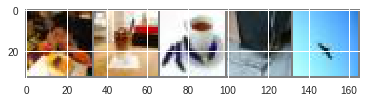

In [62]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Plot images
plot_images(torchvision.utils.make_grid(images, nrow=5, padding=1))


# print labels
print(' '.join('%8s' % classes[labels[j]] for j in range(5)))

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [41]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [0]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [0]:
def training(num_iterations):
    for epoch in range(num_iterations): # loop over the dataset multiple times
        print('Training: Epoch - (%d)'%(epoch))
        running_loss = 0.0
        
        for i, data in enumerate(trainloader, 0):
            # Get the inputs
            inputs, labels = data
            
            # wrap them in Variable
       #     inputs, labels = Variable(inputs), Variable(labels)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            
            # Print statistics
            #running_loss += loss.data[0]
            running_loss += loss.item()
            
            if i % 2000 == 1999: # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
                
                running_loss = 0.0
                
    print('Finished Training')

In [81]:
training(num_iterations=5)

Training: Epoch - (0)
[1,  2000] loss: 1.304
[1,  4000] loss: 1.366
Training: Epoch - (1)
[2,  2000] loss: 1.270
[2,  4000] loss: 1.308
Training: Epoch - (2)
[3,  2000] loss: 1.230
[3,  4000] loss: 1.254
Training: Epoch - (3)
[4,  2000] loss: 1.180
[4,  4000] loss: 1.225
Training: Epoch - (4)
[5,  2000] loss: 1.130
[5,  4000] loss: 1.179
Finished Training


GroundTruth: 
       05       09       07       05       02
Predicted: 
       05       02       07       07       02


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f0389084860>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  Fil

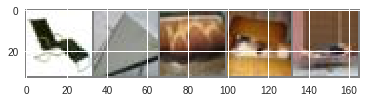

In [88]:
# plot some images from the test dataset
dataiter = iter(trainloader)
images, labels = dataiter.next()

# plot images
plot_images(torchvision.utils.make_grid(images,nrow=5, padding=1))

print('GroundTruth: \n', ' '.join('%8s' % classes[labels[j]] for j in range(5)))

# predict class labels for test images
#outputs = net(Variable(images))
outputs = net(images)

#_, predicted = torch.max(outputs.data, 1)
_, predicted = torch.max(outputs, 1)

print('Predicted: \n', ' '.join('%8s' % classes[predicted[j]]
                              for j in range(5)))

In [102]:
correct = 0
total = 0
for data in trainloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
print('Accuracy of the network: %d %%' % (
    100 * correct / total))

Accuracy of the network: 64 %
